<a href="https://colab.research.google.com/github/Nadia2916/DSSM-VAE-Model/blob/main/DSSM_VAE_cmappss_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as skd
import copy
import sys
import random
import matplotlib
import matplotlib.pyplot as plt
#import statsmodels
import sklearn
import math
import csv
from numpy.random import choice
from sklearn import datasets
from matplotlib.pyplot import figure
from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScalfrom keras import optimizers
import torch
import torch.nn as nn
from torch.distributions import Normal, Categorical
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
#import tensorflow as tf
import csv
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from numpy.random import choice
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import Dataset

pd.set_option('display.max_columns', None)

print("Pandas version: ", pd.__version__)
print("Numpy version: ", np.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Pandas version:  2.2.2
Numpy version:  2.0.2
Scikit-learn version:  1.6.1


In [2]:
## if GPU is available or not

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is not available.


In [3]:
# Check if CUDA (GPU support) is available, and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
#Adding Column name to Input files as it doesnot have column name
dependent_var = ['RemainingUsefulLife']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

Upload the train, test and Rul dataset separately for FD001/FD002/FD003/FD004

In [7]:
#upload from the computer
from google.colab import files
uploades = files.upload()

Saving train_FD001.txt to train_FD001.txt


Read the FD001 dataset (change when using FD002/FD003/FD004)

In [8]:
#read the data files(check for FD001/FD002/FD003/FD004 )
Train = pd.read_csv("train_FD001.txt", sep = "\s+", header = None, names=input_file_column_names)
Test = pd.read_csv("test_FD001.txt", sep = "\s+", header = None, names=input_file_column_names)
Rul = pd.read_csv("RUL_FD001.txt", sep = "\s+", header = None)

# Assuming you've already read the DataFrame as 'Rul'
Rul.rename(columns={0: 'True_Rul'}, inplace=True)

##PREPROCESSING

Time to Failure Count

In [9]:
#time to failure or defect for train and test
Time_to_failure = Train.groupby("UnitNumber")["Cycle"].count()
Time_to_failure_tx= Test.groupby("UnitNumber")["Cycle"].count()

Add RUL column to dataset for training

In [10]:
# Step 1: Get the maximum cycle for each unit
max_cycles = Train.groupby(Train.iloc[:, 0])[Train.columns[1]].max().reset_index()
max_cycles.columns = [Train.columns[0], 'MaxCycle']

# Step 2: Merge the maximum cycle back into the original DataFrame
train_rul = Train.merge(max_cycles, on=Train.columns[0])

# Step 3: Calculate remaining useful life for each row
train_rul['RUL'] = train_rul['MaxCycle'] - train_rul[Train.columns[1]]
# Step 3: Calculate remaining useful life for each row, clipping it to a maximum of 125
#train_rul['RUL'] = train_rul['MaxCycle'] - train_rul[Train.columns[1]]
train_rul['RUL'] = train_rul['RUL'].clip(upper=125)

# Step 4: Drop the unneeded column
train_rul = train_rul.drop('MaxCycle', axis=1)

# 'train_with_max_cycles' now contains the Remaining Useful Life (RUL) for each row
#train_rul


In [11]:
# Step 1: Get max cycles per unit
max_cycles = Test.groupby(Test.iloc[:, 0])[Test.columns[1]].max().reset_index()
max_cycles.columns = [Test.columns[0], 'MaxCycle']

# Step 2: Add True_Rul from Rul file
max_cycles['MaxCycle'] = max_cycles['MaxCycle'] + Rul['True_Rul']

# Step 3: Merge back into Test set
test_rul = Test.merge(max_cycles, on=Test.columns[0])

# Step 4: Compute RUL (real cycle degradation)
test_rul['RUL'] = test_rul['MaxCycle'] - test_rul[Test.columns[1]]

# Step 5: Optionally cap RUL (after computing it)
test_rul['RUL'] = test_rul['RUL'].clip(upper=125)

# Step 6: Drop intermediate column
test_rul = test_rul.drop('MaxCycle', axis=1)

Normalizing the selected 14 columns(coninuous sensor observations) after feature engineering

In [12]:
### create a new dataset with only the selected columns
cols_to_normalize = train_rul.iloc[:, [6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25,26]]

# Calculate the minimum and maximum values for the selected columns
min_vals = cols_to_normalize.min()
max_vals = cols_to_normalize.max()

# Perform min-max normalization on the selected columns within the train_rul DataFrame
train_rul[cols_to_normalize.columns] = (cols_to_normalize - min_vals) / (max_vals - min_vals)

In [13]:
### create a new dataset with only the selected columns
cols_to_normalize = test_rul.iloc[:, [6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25, 26]]

# Calculate the minimum and maximum values for the selected columns
min_vals_t = cols_to_normalize.min()
max_vals_t = cols_to_normalize.max()

# Perform min-max normalization on the selected columns within the train_rul DataFrame
test_rul[cols_to_normalize.columns] = (cols_to_normalize - min_vals_t) / (max_vals_t - min_vals_t)

In [14]:
#select only the columns of continuous sensor measurement nad add up with unit number
df_train = train_rul.iloc[:, [0, 1, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25,26]].copy()
#df = train_rul.iloc[:, [0, 1, 6, 7, 8, 11,12,13,26]].copy()
df_test = test_rul.iloc[:, [0, 1, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 19, 21, 24, 25,26]].copy()

##DATASET CLASS DEFINATION WITH TENSOR

In [15]:
#DATASET
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data['UnitNumber'].nunique()

    def __getitem__(self, index):
        unique_seq_nums = self.data['UnitNumber'].unique()
        seq_num = unique_seq_nums[index % len(unique_seq_nums)]

        #selecting inputs to teh network
        y = self.data[self.data['UnitNumber'] == seq_num][['SensorMeasure2','SensorMeasure3', 'SensorMeasure4', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure17', 'SensorMeasure20', 'SensorMeasure21']].values
        r = self.data[self.data['UnitNumber'] == seq_num][['RUL']].values

        # if units that are too short
        if len(y) <= lookback:
            raise ValueError(f"Sequence for unit {seq_num} is shorter than lookback ({lookback})")

        # Sliding window logic
        def create_lookback_sequences(data, lookback):
            X, Y = [], []
            for i in range(len(data) - lookback):
                X.append(data[i:i+lookback])
                Y.append(data[i+lookback])
            return np.array(X), np.array(Y)
        Y, R = create_lookback_sequences(y, lookback)

        # Convert to tensors
        seq_tensor = torch.tensor(y, dtype=torch.float)
        true_rul= torch.tensor(r, dtype=torch.float)
        seq_len = seq_tensor.shape[0]
        return seq_tensor, seq_num, seq_len, true_rul

###MODEL STRUCTURE

In [16]:
class RVAEWithRULPrediction(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, categorical_latent_size, lookback, num_layers, bias=True, dropout_prob=0):
        super(RVAEWithRULPrediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.categorical_latent_size = categorical_latent_size
        self.lookback = lookback
        self.num_layers = num_layers

        # Encoder
        self.encoder_input = nn.Linear(input_size, hidden_size)                                        #input layer
        self.encoder_rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True) #RNN layer
        self.encoder_fc_mean = nn.Linear(hidden_size, latent_size)                                    #x_mean layer
        self.encoder_fc_logvar = nn.Linear(hidden_size, latent_size)                                  #x_logvar layer
        self.encoder_fc_categorical = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),                                                      #m_logit layer
            nn.ReLU(),
            nn.Linear(hidden_size, categorical_latent_size)
        )

        # Prior
        self.prior_rnn = nn.LSTM(latent_size + categorical_latent_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.prior_fc_mean = nn.Linear(hidden_size, latent_size)
        self.prior_fc_logvar = nn.Linear(hidden_size, latent_size)
       # self.prior_fc_logits = nn.Linear(hidden_size, categorical_latent_size)
        self.prior_fc_logits = nn.Sequential(
                    nn.Linear(hidden_size, hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, categorical_latent_size)
                    )

        # Decoder
        self.decoder_input1 = nn.Linear(latent_size + categorical_latent_size, hidden_size)                #input layer
        self.decoder_input2 = nn.Linear(hidden_size, hidden_size)
        self.decoder_input3 = nn.Linear(hidden_size, hidden_size)
        self.decoder_rnn_y = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)    #RNN layer
        self.decoder_output_y = nn.Sequential(nn.Linear(hidden_size, input_size), nn.Sigmoid())             #y_mean layer
        self.decoder_output_logvar = nn.Sequential(nn.Linear(hidden_size, input_size), nn.Sigmoid())        #y_logvar layer

        # RUL Decoder
        self.decoder_rnn_rul = nn.LSTM(latent_size, hidden_size, num_layers=num_layers, batch_first=True)    #RL RNN layer
        self.rul_predictor_mean = nn.Linear(hidden_size, 1)                                                  #RL mean layer
        self.rul_predictor_logvar = nn.Linear(hidden_size, 1)                                                #RL logvar layer

        #definations of functions
    #defination of encoder
    def encode(self, seq_tensor):
        if seq_tensor.dim() == 3 and seq_tensor.shape[1] == self.input_size:
            seq_tensor = seq_tensor.permute(0, 2, 1)
        y = self.encoder_input(seq_tensor)
        y, _ = self.encoder_rnn(y)
        x_mean = self.encoder_fc_mean(y)
        x_logvar = self.encoder_fc_logvar(y)
        categorical_logits = self.encoder_fc_categorical(y)
        return y, x_mean, x_logvar, categorical_logits

    #defination of prior
    def get_priors(self, x, m):
        if m.dim() == 2:
            m = m.unsqueeze(-1).expand(-1, -1, self.categorical_latent_size)
        elif m.size(-1) != self.categorical_latent_size:
            m = m[:, :, :1].expand(-1, -1, self.categorical_latent_size)

        prior_input = torch.cat([x[:, :-1], m[:, :-1]], dim=-1)
        prior_input = F.pad(prior_input, (0, 0, 1, 0), value=0.0)
        h, _ = self.prior_rnn(prior_input)
        return self.prior_fc_mean(h), self.prior_fc_logvar(h), self.prior_fc_logits(h)

    #defination of decoder
    def decode(self, x, m):
        if m.dim() == 2:
            m = m.unsqueeze(-1)
        output = torch.cat((x, m), dim=-1)
        output = self.decoder_input1(output)
        output = self.decoder_input2(output)
        output = self.decoder_input3(output)
        output, _ = self.decoder_rnn_y(output)
        return self.decoder_output_y(output), self.decoder_output_logvar(output)

    #defination of rul decoder
    def decode_rul(self, x):
        output, _ = self.decoder_rnn_rul(x)
        return self.rul_predictor_mean(output), self.rul_predictor_logvar(output)

    #defination of reparameterize method
    def reparameterize(self, x_mean, x_logvar, categorical_logits, num_passes=20):
        std = torch.exp(0.5 * x_logvar)
        x_samples, m_samples = [], []
        T = x_mean.size(1)


        for _ in range(num_passes):
          #gaussian for x
            eps = torch.randn_like(std)
            x = x_mean + eps * std
          #gumble softmax for m
            m = F.gumbel_softmax(categorical_logits, tau=0.05, hard=True)

           #SSM dynamics for latent x and m
            for t in range(1, T):
                x[:, t] = x[:, t] + x[:, t-1] + m[:, t-1]
                m[:, t] = m[:, t] + m[:, t-1]

            t = torch.linspace(0.0, 1.0, T, device=m.device).view(1, T, 1)
            d = torch.linspace(1.0, 0.0, T, device=x.device).view(1, T, 1)
            threshold = 0.5
            m = (t > threshold).float()
            n = 0.1 * torch.randn_like(x)
            x = torch.sigmoid(x) * d + n
            x = torch.clamp(x, 0, 1)

            x_samples.append(x)
            m_samples.append(m)

        # Monte Carlo averaging
        x = torch.mean(torch.stack(x_samples), dim=0)
        m = torch.mean(torch.stack(m_samples), dim=0)

        return x, m


    #defination of forward method
    def forward(self, seq_tensor, seq_len=None, true_rul=None, lookback=None):
        if lookback is not None:
            seq_tensor = seq_tensor[:, :, -lookback:]

        y, x_mean, x_logvar, categorical_logits = self.encode(seq_tensor)
        x, m = self.reparameterize(x_mean, x_logvar, categorical_logits)
        prior_mean, prior_logvar, prior_logits = self.get_priors(x, m)

        y_mean, y_logvar = self.decode(x, m)
        variance_scale = 0.09
        y_hat = y_mean + variance_scale * torch.exp(0.5 * y_logvar) * torch.randn_like(y_mean)
        y_hat = y_hat.permute(0, 2, 1)

        rul_mean, rul_logvar = self.decode_rul(x)
        variance_scale = 0.01
        rul_prediction = rul_mean + variance_scale * torch.exp(0.5 * rul_logvar) * torch.randn_like(rul_mean)
        rul_prediction = rul_prediction.squeeze(-1).permute(0, 1)

        return y_hat, x_mean, x_logvar, categorical_logits, x, m, rul_mean, rul_prediction, prior_mean, prior_logvar, prior_logits


##HYPERPARAMETERS

In [19]:
# Hyperparameters used
input_size =14               #sensor input size
hidden_size = 32             #hidden neuron number
latent_size = 1              # continuous latent size,x
categorical_latent_size = 1  # Discrete categorical latent size,m
learning_rate = 0.0001       # learning rate
num_epochs = 5               # training epoch no
lookback=5                   #lookback period for RNN
num_layers= 2                #number of LSTM layer
beta = 1                     #beta for categorical
num_passes=20                #monte carlo sample

##DATALOADER

In [20]:
#loading thh train and test data
data = df_train
data_2= df_test
batch_size= 1

# Split the data into training, validation based on the number of sequences
unique_seq_nums = data['UnitNumber'].unique()
num_sequences = len(unique_seq_nums)
train_size = int(0.8* num_sequences)
#test_size = int(0.1 * num_sequences)
val_size = int(0.2 * num_sequences)

# Split the unique sequence numbers into training, validation, and testing sets
train_seq_nums = unique_seq_nums[:train_size]
val_seq_nums = unique_seq_nums[train_size:train_size+val_size]
test_seq_nums = unique_seq_nums[:]

# Create the train dataset and data loader
train_data = data[data['UnitNumber'].isin(train_seq_nums)]
train_dataset = MyDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Create the validation dataset and data loader
val_data = data[data['UnitNumber'].isin(val_seq_nums)]
val_dataset = MyDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create the test dataset and data loader
test_data = data_2[data_2['UnitNumber'].isin(test_seq_nums)]
test_dataset = MyDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# MODEL
model = RVAEWithRULPrediction(input_size, hidden_size, latent_size, categorical_latent_size, lookback, num_layers)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
model

RVAEWithRULPrediction(
  (encoder_input): Linear(in_features=14, out_features=32, bias=True)
  (encoder_rnn): LSTM(32, 32, num_layers=2, batch_first=True)
  (encoder_fc_mean): Linear(in_features=32, out_features=1, bias=True)
  (encoder_fc_logvar): Linear(in_features=32, out_features=1, bias=True)
  (encoder_fc_categorical): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (prior_rnn): LSTM(2, 32, num_layers=2, batch_first=True)
  (prior_fc_mean): Linear(in_features=32, out_features=1, bias=True)
  (prior_fc_logvar): Linear(in_features=32, out_features=1, bias=True)
  (prior_fc_logits): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (decoder_input1): Linear(in_features=2, out_features=32, bias=True)
  (decoder_input2): Linear(in_features=32, out_features=32, bias=True)
  (decoder

##TRAINNING

In [22]:
# Disable CuDNN for RNNs
torch.backends.cudnn.enabled = False

# Move the model to the GPU if available
if torch.cuda.is_available():
    model.to('cuda')

# Record the start time
start_time = time.time()

# Define a list to store the training and validation loss values for each epoch
train_loss = []
val_loss = []
kl_loss= []
catkl_loss=[]
rul_loss=[]
train_rmse = []
validation_rmse = []

# Define lists to store the predicted outputs and input sequence tensors
predicted_outputs = []
input_sequences = []
con_recon_loss = []
dis_BCE_loss= []
RMSE_con_latent = []
RMSE_dis_latent = []
true_rul_list= []
rul_prediction_list = []
rul_prediction_rmse=[]

# Define lists to store the latent state tensors
continuous_latent = []
discrete_latent = []

# Set the initial best validation loss to a very large number
best_val_loss = float('inf')

# Set the number of epochs to wait before stopping if validation loss doesn't improve
patience = 50

# Initialize the number of epochs without improvement
num_epochs_no_improve = 0

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for seq_tensor, seq_len, seq_num, true_rul in train_dataloader:
        seq_tensor = seq_tensor.to(device)
        true_rul = true_rul.to(device)

        # Forward pass
        y_hat, x_mean, x_logvar, categorical_logits, x, m, rul_prediction, rul_mean, prior_mean, prior_logvar, prior_logits = model(seq_tensor, seq_len, true_rul)
        y_hat = y_hat.permute(0, 2, 1)

        #reconstruction loss
        recon_loss = nn.MSELoss()(seq_tensor, y_hat).to(device)

        #kl divergence loss
        kl_loss = 0.5 * torch.sum(
            prior_logvar - x_logvar +
            (torch.exp(x_logvar) + (x_mean - prior_mean) ** 2) / torch.exp(prior_logvar) - 1
        ) / seq_tensor.size(0)

        #categorical kl loss
        q_m = F.softmax(categorical_logits, dim=-1)
        log_q_m = F.log_softmax(categorical_logits, dim=-1)
        log_p_m = F.log_softmax(prior_logits, dim=-1)
        categorical_kl_loss = torch.sum(q_m * (log_q_m - log_p_m)) / seq_tensor.size(0)

        #rul loss
        rul_prediction = rul_prediction.squeeze(-1)
        true_rul = true_rul.squeeze()
        if len(true_rul.shape) == 1:
            true_rul = true_rul.unsqueeze(0)

        rul_loss= nn.MSELoss()(rul_prediction, true_rul).to(device)

        #total loss
        loss = recon_loss + beta * (kl_loss + categorical_kl_loss) + rul_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * seq_tensor.size(0)

        #appending the data
        predicted_outputs.append(y_hat)
        input_sequences.append(seq_tensor)
        continuous_latent.append(x)
        discrete_latent.append(m)
        true_rul_list.append(true_rul)
        rul_prediction_list.append(rul_prediction)

    avg_loss = total_loss / len(train_dataset)
    train_loss.append(avg_loss)
    train_rmse.append(torch.sqrt(recon_loss).item())
    con_recon_loss.append(recon_loss)
    rul_prediction_rmse.append(torch.sqrt(rul_loss_val).item())


#validation loop
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        for seq_tensor, seq_len, seq_num, true_rul in val_dataloader:
            seq_tensor = seq_tensor.to(device)
            true_rul = true_rul.to(device)

            # Forward pass
            y_hat, x_mean, x_logvar, categorical_logits, x, m, rul_prediction, rul_mean, prior_mean, prior_logvar, prior_logits = model(seq_tensor, seq_len, true_rul)
            y_hat = y_hat.permute(0, 2, 1)

            #reconstruction loss validation
            recon_loss_val = nn.MSELoss()(seq_tensor, y_hat).to(device)

            # Kl loss validation
            kl_loss_val = 0.5 * torch.sum(
                prior_logvar - x_logvar +
                (torch.exp(x_logvar) + (x_mean - prior_mean) ** 2) / torch.exp(prior_logvar) - 1
            ) / seq_tensor.size(0)

            # Categorical Kl loss validation
            q_m = F.softmax(categorical_logits, dim=-1)
            log_q_m = F.log_softmax(categorical_logits, dim=-1)
            log_p_m = F.log_softmax(prior_logits, dim=-1)
            categorical_kl_loss_val = torch.sum(q_m * (log_q_m - log_p_m)) / seq_tensor.size(0)

            # rul loss validation
            rul_prediction = rul_prediction.squeeze(-1)
            true_rul = true_rul.squeeze()
            if len(true_rul.shape) == 1:
                true_rul = true_rul.unsqueeze(0)
            rul_loss_val = nn.MSELoss()(rul_prediction, true_rul).to(device)

            #total loss validation
            loss_val = recon_loss_val + kl_loss_val + categorical_kl_loss_val + rul_loss_val
            total_val_loss += loss_val.item() * seq_tensor.size(0)

        avg_val_loss = total_val_loss / len(val_dataset)
        val_loss.append(avg_val_loss)
        validation_rmse.append(torch.sqrt(recon_loss_val).item())

    print(f'Epoch {epoch+1} Training RMSE: {train_rmse[-1]:.7f} Validation RMSE: {validation_rmse[-1]:.7f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        num_epochs_no_improve = 0
        torch.save(model.state_dict(), 'model.pt')
    else:
        num_epochs_no_improve += 1

    if num_epochs_no_improve == patience:
        print(f'No improvement in validation loss for {patience} epochs. Training stopped.')
        break
#training time
end_time = time.time()
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds")

Epoch 1 Training RMSE: 0.1544956 Validation RMSE: 0.1573542
Epoch 2 Training RMSE: 0.1473098 Validation RMSE: 0.1459936
Epoch 3 Training RMSE: 0.1430088 Validation RMSE: 0.1403597
Epoch 4 Training RMSE: 0.1411450 Validation RMSE: 0.1364100
Epoch 5 Training RMSE: 0.1370805 Validation RMSE: 0.1331329
Training took 4093.91 seconds


##TESTING

In [23]:
# Load the best trained model
model.load_state_dict(torch.load('model.pt'))
model.eval()
model.to(device)

# Initialize tracking variables
test_loss = 0
test_rmse = []
rul_prediction_test_rmse = []
test_recon_loss = []
test_kl_loss = []
test_catkl_loss = []
test_rul_loss = []

# For storing outputs
predicted_outputs_test = []
input_sequences_test = []
true_rul_list_test = []
rul_prediction_list_test = []
latent_continuous_test = []
latent_discrete_test = []

with torch.no_grad():
    for seq_tensor, seq_len, seq_num, true_rul in test_dataloader:
        seq_tensor = seq_tensor.to(device)
        true_rul = true_rul.to(device)

        # Forward pass
        y_hat, x_mean, x_logvar, categorical_logits, x, m, rul_prediction, rul_mean, prior_mean, prior_logvar, prior_logits = model(seq_tensor, seq_len, true_rul)
        y_hat = y_hat.permute(0, 2, 1)

        # Reconstruction loss
        recon_loss_val = nn.MSELoss()(seq_tensor, y_hat).to(device)

        # KL divergence (continuous latent)
        kl_loss_val = 0.5 * torch.sum(
            prior_logvar - x_logvar +
            (torch.exp(x_logvar) + (x_mean - prior_mean) ** 2) / torch.exp(prior_logvar) - 1
        ) / seq_tensor.size(0)

        # KL divergence (discrete latent)
        q_m = F.softmax(categorical_logits, dim=-1)
        log_q_m = F.log_softmax(categorical_logits, dim=-1)
        log_p_m = F.log_softmax(prior_logits, dim=-1)
        categorical_kl_loss_val = torch.sum(q_m * (log_q_m - log_p_m)) / seq_tensor.size(0)

        # RUL loss
        rul_prediction = rul_prediction.squeeze(-1)
        true_rul = true_rul.squeeze()
        if len(true_rul.shape) == 1:
            true_rul = true_rul.unsqueeze(0)
        rul_loss_val = nn.MSELoss()(rul_prediction, true_rul).to(device)

        # Total test loss
        loss_val = recon_loss_val + beta * (kl_loss_val + categorical_kl_loss_val) + rul_loss_val
        test_loss += loss_val.item() * seq_tensor.size(0)

        # Store per-batch stats
        test_rmse.append(torch.sqrt(recon_loss_val).item())
        rul_prediction_test_rmse.append(torch.sqrt(rul_loss_val).item())
        test_recon_loss.append(recon_loss_val.item())
        test_kl_loss.append(kl_loss_val.item())
        test_catkl_loss.append(categorical_kl_loss_val.item())
        test_rul_loss.append(rul_loss_val.item())

        # Store outputs
        predicted_outputs_test.append(y_hat)
        input_sequences_test.append(seq_tensor)
        true_rul_list_test.append(true_rul)
        rul_prediction_list_test.append(rul_prediction)
        latent_continuous_test.append(x)
        latent_discrete_test.append(m)

# Average stats
avg_test_loss = test_loss / len(test_dataset)
avg_test_rmse = sum(test_rmse) / len(test_rmse)
avg_rul_rmse = sum(rul_prediction_test_rmse) / len(rul_prediction_test_rmse)

# Final reporting
print(f"Test RMSE: {avg_test_rmse:.7f}")



Test RMSE: 0.1670714


##PLOT RESULT

Reconstructed Sensor Observation

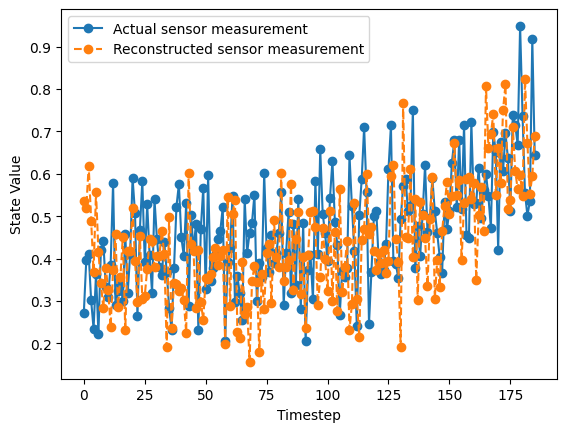

In [24]:
# Choose the index and value you want to plot
index = 23# Example index
value_index = 1# Choose a value index from 0 to 13 for sensor

# Extract the reconstructed output and input sequence for the chosen index
reconstructed_output = predicted_outputs_test[index][0, :, value_index]
input_sequence = input_sequences_test[index][0, :, value_index]

# Create the x-axis values based on the sequence length
x = np.arange(reconstructed_output.shape[0])
#plt.figure(figsize=(10,6),dpi=300)
plt.savefig('y.pdf', dpi=300)
# Create the plot
plt.plot(x, input_sequence,label='Actual sensor measurement', marker='o', linestyle='-')
plt.plot(x, reconstructed_output.detach().numpy(),label='Reconstructed sensor measurement', marker='o', linestyle='--')


plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()

# Set a higher DPI for the plot
plt.savefig('y1_train.pdf', dpi=700)
#plt.show()

Continuous Latent State Estimation

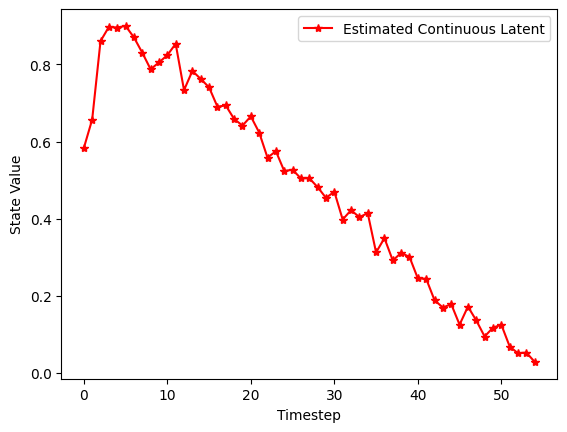

In [25]:
# Choose the batch index for plotting
batch_index =8

# Access the true and estimated continuous latent tensors for the chosen batch index
#true_continuous_latent = con_latent_true[batch_index].squeeze().detach().numpy()
estimated_continuous_latent = latent_continuous_test[batch_index].squeeze().detach().numpy()

# Create a time step array
time_steps = np.arange(estimated_continuous_latent.shape[0])

# Plot the true values of the continuous latent variable
#plt.plot(time_steps, true_continuous_latent, '-*', label='True Continuous Latent', color= "green")

# Plot the estimated values of the continuous latent variable
plt.plot(time_steps, estimated_continuous_latent, '-*', label='Estimated Continuous Latent', color="red")

# Add text annotations
#plt.text(0.05, 0.95, f"Batch Index: {batch_index}", transform=plt.gca().transAxes, ha='left', va='bottom')
plt.savefig('x.pdf', dpi=300)
# Set the plot title and labels
#plt.title('Estimated Discrete Latent Variables'.format(batch_index))
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()
#plt.show()


Discrete Latent State Observation

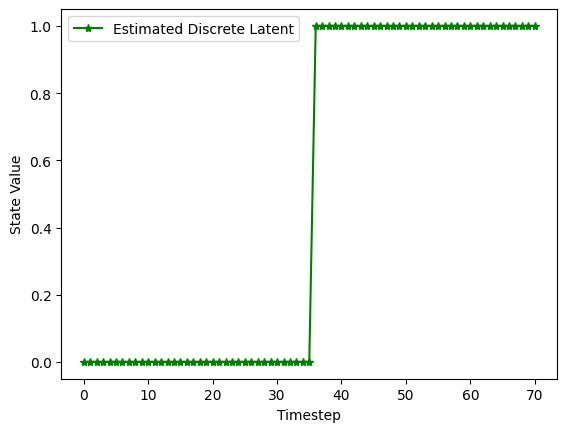

In [26]:
#Choose the batch index for plotting
batch_index = 66

# Access the true and estimated continuous latent tensors for the chosen batch index
#true_discrete_latent = dis_latent_true[batch_index].squeeze().detach().numpy()
estimated_discrete_latent = latent_discrete_test[batch_index].squeeze().detach().numpy()

# Create a time step array
time_steps = np.arange(estimated_discrete_latent.shape[0])

# Plot the true values of the continuous latent variable
#plt.plot(time_steps, true_discrete_latent, '-*', label='True Discrete Latent', color= "green")

# Plot the estimated values of the continuous latent variable
plt.plot(time_steps, estimated_discrete_latent, '-*', label='Estimated Discrete Latent', color= "green")

plt.savefig('m.pdf', dpi=300)
# Add text annotations
#plt.text(0.05, 0.95, f"Batch Index: {batch_index}", transform=plt.gca().transAxes, ha='left', va='bottom')

# Set the plot title and labels
#plt.title('Estimated Discrete Latent Variables'.format(batch_index))
plt.xlabel('Timestep')
plt.ylabel('State Value')
plt.legend()
plt.show()

RMSE for Test RUL estimation of Last point

In [75]:
# Run this after more epochs to reproduce the result reported
last_true_values = []
last_estimated_values = []

# Collect the last timestep RUL values for each unit
for true_rul, estimated_rul in zip(true_rul_list_test, rul_prediction_list_test):
    last_true = true_rul[-1, -1].item()  # shape: (timesteps, 1)
    last_estimated = estimated_rul[-1, -1].item()
    max_val = 125
    min_val = 7

    # Denormalize
    denorm_true = last_true * (max_val - min_val) + min_val
    denorm_estimated = last_estimated * (max_val - min_val) + min_val


    last_true_values.append(denorm_true)
    last_estimated_values.append(denorm_estimated)

# Compute RMSE
rmse = np.sqrt(np.mean([(t - e) ** 2 for t, e in zip(last_true_values, last_estimated_values)]))
print(f'RMSE for last values: {rmse:.4f}')

RMSE for last values: 14.8191


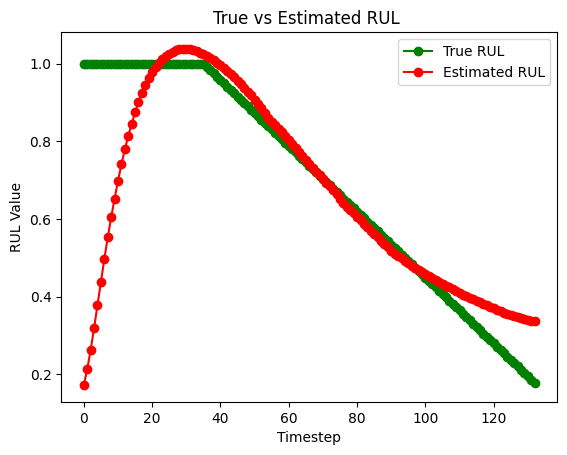

In [103]:
# Choose the batch index for plotting
batch_index = 17

# Access the true and estimated continuous latent tensors for the chosen batch index
true = true_rul_list_test[batch_index].squeeze().detach().cpu().numpy()
estimated= rul_prediction_list_test[batch_index].squeeze().detach().cpu().numpy()

# Create a time step array
time_steps = np.arange(true.shape[0])
plt.savefig('r.pdf', dpi=300)
# Plot the true values of the continuous latent variable
plt.plot(time_steps, true, '-o', label='True RUL', color= "green")

# Plot the estimated values of the continuous latent variable
plt.plot(time_steps, estimated, '-o', label='Estimated RUL', color="red")

# Add text annotations
#plt.text(0.05, 0.95, f"Batch Index: {batch_index}", transform=plt.gca().transAxes, ha='left', va='bottom')

# Set the plot title and labels
plt.title('True vs Estimated RUL ')
plt.xlabel('Timestep')
plt.ylabel('RUL Value')
plt.legend()
#plt.show()
# Set a higher DPI for the plot
#plt.savefig('rul10_train.pdf', dpi=700)